# Character level RNN (LSTM)

We will be building a text generator based of Mukhtar Auezov novels. Filrst, __make sure to upload the text file you want to generate text from__.

We will be using LSTM because they work well with long sequences of data. By long sequence, it was meant to say that if we pass for example sequence length as 50, then LSTM is less likely to have exploding/vanishing gradients, whereas RNN most defintely will.

Let's fucking nail this project. I hope I can finish it within today.

In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

import time
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

## Reading and preprocessing of the data

Data is simply concatenation of 3 books of kazakh writer Mukhtar Auezov - "The Path of Abay I", "The Path of Abay II", and "Karash-karash" into one text file.


In [3]:
FILE_NAME = 'whole.txt'

with open(FILE_NAME, 'r') as f:
  text=f.read()

chars = tuple(set(text))

print('First 100 characters of the text:')
print(repr(text[:100]))

First 100 characters of the text:
'Абай жолы. І кітап\n\xa0\nҚАЙТҚАНДА\n\n 1\n\nҮш күндік жолдың бүгінгі, соңғы күніне шәкірт бала барын салды.\n'


In [4]:
int2char = dict(enumerate(chars))
char2int = {cc: ii for ii, cc in int2char.items()}

encoded = np.array([char2int[cc] for cc in text])

print('First 100 encoded characters of the text:')
print(repr(encoded[:100]))

First 100 encoded characters of the text:
array([ 72,   6, 106,  85,  69,  63,  47,  88,  51,  31,  69,  17,  69,
        60,  33,  18, 106,   1, 111,  52, 111,  56,  72,  74,  61,  56,
        72,  29,  82,  72, 111, 111,  69,   3, 111, 111,  75,  19,  69,
        60,  99,  55,  30,  33,  60,  69,  63,  47,  88,  30,  51,  34,
        69,   6,  99,  59,  33,  55,  59,  33,  67,  69, 101,  47,  34,
        95,  51,  69,  60,  99,  55,  33,  55,  36,  69,  19,  97,  60,
        33,  15,  18,  69,   6, 106,  88, 106,  69,   6, 106,  15,  51,
        55,  69, 101, 106,  88,  30,  51,  31, 111])


__NOTE__:

Regarding the `*` operation in python:
* Single star `*` operation unpacks the list/tuple contents
* Double start `**`operation unpack the dictionary contents

Code example:
```
>>> def foo(x,y,z):
              print("x=" + str(x))
              print("y=" + str(y))
              print("z=" + str(z))
              
>>> mylist = [1,2,3]
>>> foo(*mylist)
x=1
y=2
z=3

>>> mydict = {'x':1,'y':2,'z':3}
>>> foo(**mydict)
x=1
y=2
z=3

>>> mytuple = (1, 2, 3)
>>> foo(*mytuple)
x=1
y=2
z=3

>>> def sum(*values):
              s = 0
              for v in values:
                  s = s + v
              return s

>>> sum(1, 2, 3, 4, 5)
15

>>> def get_a(**values):
              return values['a']

>>> get_a(a=1, b=2)
a

>>> def sum(*values, **options):
              s = 0
              for i in values:
                  s = s + i
              if "neg" in options:
                  if options["neg"]:
                      s = -s
              return s

>>> sum(1, 2, 3, 4, 5)
15
>>> sum(1, 2, 3, 4, 5, neg=True)
-15
>>> sum(1, 2, 3, 4, 5, neg=False)
15
```

In [0]:
def one_hot_encode(arr, n_labels):
  # arr argument is one dimensional vector of int encoded values
  
  # Create vector of new size that has the right shape of one-hot encoding
  one_hot_vector = np.zeros((arr.size, n_labels))
  
  # Transform the values into one-hot encodings
  one_hot_vector[np.arange(arr.size), arr.flatten()] = 1
  
  # Save the shape, flatten the array, and encode the values
  return one_hot_vector.reshape((*arr.shape, n_labels))

In [6]:
temp = np.array([0,1,2,3,4,5,6,7,8,9]).reshape(2,5)
print(f'Input array is:\n{temp}\n')
print(f'Encoded array is:\n{one_hot_encode(temp, 10)}')


Input array is:
[[0 1 2 3 4]
 [5 6 7 8 9]]

Encoded array is:
[[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]]


## Creating batches

This one is interesting part of the coding. So, the inputs for this function will be `array`, `batch_size`, `seq_length`.

It should return a generator, that will output the values for input - `x` and output `y`. `y` is `[batch_size,sequence_length]` array shifted by one from `x`

__NOTE__:

So, at first I was very certain that the way I would do the batch generating would be perfectly logical and corrent, but never in my life I was so wrong.

So, with the shape of array `[batch_size,sequence_length]` it is hard to target values of current batch. 

For instance:

`input_array` = `[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]`

`transformed_array` = 
```
[[[ 0  1  2  3]
  [ 4  5  6  7]]
 [[ 8  9 10 11]
  [12 13 14 15]]]
  ```
  
and `x`, `y` should be as follow for the first batch:
 
`x`: 
```
[[ 0  1  2  3]
  [ 4  5  6  7]]
```
and `y`:
```
[[ 1  2  3  4]
  [ 5  6  7  8]]

```

So with former `transformed array` it is really difficult to get the targets for input batch, so instead we could organize our `transformed_array` as follows:
```
[[ 0  1  2  3  4  5  6  7]
 [ 8  9 10 11 12 13 14 15]]
```
sliding by window of `[batch_size, seq_len]`, so the resulting `x`'s and `y`'s will be as follows:
`x`:
```
[[0  1  2  3]   [[ 4  5  6  7]
  [8  9 10 11]]   [12 13 14 15]]
```
`y`:
```
[[1  2  3  4]   [[ 5  6  7  0]
  [9 10 11 12]]   [13 14 15  8]]
```

So, in total we will have `batch_size` sequences that do not have proper output - the last batch, but if the data is big, it should cause any problem

In [0]:
def get_mini_batches(array, batch_size, seq_length):
  
  items_per_batch = batch_size * seq_length
  num_batches = array.shape[0] // items_per_batch
  array = array[:num_batches * items_per_batch]
  
  n_shape = (batch_size, seq_length*num_batches, *array.shape[1:])
  array = array.reshape(n_shape)
  
  for i in range(0, array.shape[1], seq_length):
    x = array[:, i:i+seq_length]
    y = np.zeros_like(x)
    try:
      y[:,:-1], y[:,-1] = x[:,1:], array[:,i+seq_length]
    except IndexError:
      y[:,:-1], y[:,-1] = x[:,1:], array[:,0]
    yield x, y
  

### Testing shapes

In [8]:
temp = np.arange(22)
print('With batch size: 2, sequence length: 3 we have following:\n')
print(f'Our original array is:\n{temp}\n')
print(f'Transformed array is:\n{temp.reshape(2,-1)}\n')

gen = get_mini_batches(temp, 2, 3)
x, y = next(gen)
print(f'First batch of mini-sequence (input and target):\n{x}\n\n{y}\n\n')

x, y = next(gen)
print(f'Second batch of mini-sequence (input and target):\n{x}\n\n{y}\n\n')

x, y = next(gen)
print(f'Third batch of mini-sequence (input and target):\n{x}\n\n{y}\n\n')

print('Make sure to understand that instead of integer array (values), we will \nhave one-hot encoded vectors of vocabulary length, i.e. different shape.')

With batch size: 2, sequence length: 3 we have following:

Our original array is:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]

Transformed array is:
[[ 0  1  2  3  4  5  6  7  8  9 10]
 [11 12 13 14 15 16 17 18 19 20 21]]

First batch of mini-sequence (input and target):
[[ 0  1  2]
 [ 9 10 11]]

[[ 1  2  3]
 [10 11 12]]


Second batch of mini-sequence (input and target):
[[ 3  4  5]
 [12 13 14]]

[[ 4  5  6]
 [13 14 15]]


Third batch of mini-sequence (input and target):
[[ 6  7  8]
 [15 16 17]]

[[ 7  8  0]
 [16 17  9]]


Make sure to understand that instead of integer array (values), we will 
have one-hot encoded vectors of vocabulary length, i.e. different shape.


In [9]:
batches = get_mini_batches(encoded, 8, 50)
x, y = next(batches)

# printing out the first 10 items in a sequence
print('Testing on actual data:\n')
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

Testing on actual data:

x
 [[ 72   6 106  85  69  63  47  88  51  31]
 [ 36  55  69  60  36  76  30  36  69 106]
 [106 101  51   1 111  64 106  85  18  64]
 [ 55  69 101  47  34  69  95 106  55 106]
 [ 88  69  63  99  15  20  36  60  60  36]
 [ 69  63  47  15  95 106  69 106  18  18]
 [  1  69  60  36  18  35   1  67  69  20]
 [ 69  63 106  11 106   1  69  36 101  18]]

y
 [[  6 106  85  69  63  47  88  51  31  69]
 [ 55  69  60  36  76  30  36  69 106 101]
 [101  51   1 111  64 106  85  18  64 106]
 [ 69 101  47  34  69  95 106  55 106 111]
 [ 69  63  99  15  20  36  60  60  36  69]
 [ 63  47  15  95 106  69 106  18  18  51]
 [ 69  60  36  18  35   1  67  69  20  47]
 [ 63 106  11 106   1  69  36 101  18  33]]


## Model LSTM

LSTM is a little complicated than RNN. It has more complex structure than RNN. Below is the structure of the LSTM:

![LSTM](https://res.mdpi.com/information/information-10-00105/article_deploy/html/images/information-10-00105-g002.png)

So, LSTM has 4 gates:
* Input gate - $i_t$ 
* Forget gate - $i_f$
* Cell gate - $g_i$
* Output gate - $o_i$

and 2 states:
* Cell state - $c_i$
* Hidden state $h_i$

In number, it looks as follows:
$$
f_{t}=\sigma(W_{if}x_{t} + b_{if} + W_{hhf}h_{t-1} + b_{hhf}) \\
i_{t}=\sigma(W_{ii}x_{t} + b_{ii} + W_{hhi}h_{t-1} + b_{hhi}) \\
g_{t}=tanh(W_{ig}x_{t} + b_{ig} + W_{hhg}h_{t-1} + b_{hhg}) \\
o_{t}=\sigma(W_{io}x_{t} + b_{io} + W_{hho}h_{t-1} + b_{hho}) \\
c_{t}=f_{t}\times c_{t-1} + i_{t}\times g_{t} \\
h_{t}= o_{t}\times tanh(c_{t})\\
$$

where $W_{if, ii, ig, io}\in R^{m\times n}$, $x_i\in R^{n\times 1}$, $W_{hhf, hhi, hhg, hho}\in R^{m\times m}$, $h_i\in R^{m\times 1}$ and $\times$ is Hadamard product (like matrix addition, except it is multiplication).

Inputs for __LSTM__:

>__Input__
* __input__ of shape _(seq_len, batch, input_size)_: tensor containing the features of the input sequence.
* __h_0__ of shape _(num_layers * num_directions, batch, hidden_size)_: tensor containing the initial hidden state for each element in the batch. Defaults to zero if not provided. If the RNN is bidirectional, `num_directions` should be 2, else it should be 1.
* __c_0__ of shape (_num_layers * num_directions, batch, hidden_size_): tensor containing the initial cell state for each element in the batch.
>
>If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
>
>__Output__
* __output__ of shape _(seq_len, batch, num_directions * hidden_size)_: tensor containing the output features `(h_t)` from the last layer of the RNN, for each `t`.
* __h_n__ of shape _(num_layers * num_directions, batch, hidden_size)_: tensor containing the hidden state for `t = seq_len`.
* __c_n__ of shape (_num_layers * num_directions, batch, hidden_size_): tensor containing the cell state for t = seq_len.



For reference, please follow this link regarding [Pytorch's `LSTM class`](https://pytorch.org/docs/stable/nn.html#lstm)


Below is class definition of LSTM with option of switching to GRU and RNN cells for comparison aims.

In [0]:
class CharRNN(nn.Module):
  
  def __init__(self, tokens, n_hidden=256, n_layers=2, 
               dropout=0.5, mode='LSTM'):
    
    super().__init__()
    self.drop_val = dropout
    self.n_layers = n_layers
    self.n_hidden = n_hidden
    self.mode = mode
    
    self.chars = tokens
    self.int2char = dict(enumerate(tokens))
    self.char2int = {cc: ii for ii, cc in self.int2char.items()}
    
    if mode == 'LSTM':
      self.rnn = nn.LSTM(len(tokens), n_hidden, n_layers, 
                         batch_first=True, dropout=dropout)
    elif mode == 'GRU':
      self.rnn = nn.GRU(len(tokens), n_hidden, n_layers, 
                        batch_first=True, dropout=dropout)
    else:
      self.rnn = nn.RNN(len(tokens), n_hidden, n_layers, 
                        batch_first=True, dropout=dropout)
    
    
    self.dropout = nn.Dropout(dropout)
    
    self.fc = nn.Linear(n_hidden, len(tokens))
  
  def forward(self, b_x, b_h):
    
    out, hidden = self.rnn(b_x, b_h)
    
    out = self.dropout(out)
#     Regarding the contiguous refer to 
#     https://stackoverflow.com/questions/48915810/pytorch-contiguous
    out = out.contiguous().view(-1, self.n_hidden)
    out = self.fc(out)
    
    return out, hidden

__NOTE__: 

We need to have to _contigious_ output in order to compute the loss, since the criterion function (_CrossEntropyLoss_) will expect the outputs to be of the shape `[N, C]`, where `N` is the number of the items, and `C` is the classes (class scores).

Regarding the __`contiguous`__ - sets the vectors aligned, since some operations during backpropagation require vectors to be contiguous. More on [here](https://stackoverflow.com/questions/48915810/pytorch-contiguous)

---
### Testing model input and output shapes

In [23]:
print('Testing model input-output\n')
seq_length = 50
input_size = 100
output_size = 200
hidden_size = 400
print(f'Input size: {input_size}, sequence length: {seq_length}, output size: {output_size}, hidden size: {hidden_size}\n')

lstm = nn.LSTM(input_size, hidden_size, 2, batch_first=True)
b_x = torch.Tensor(np.random.randn(1,seq_length,input_size))
print(f'Shape of input data: {b_x.shape}\n')

out, hidden = lstm(b_x, None)

print(f'Output shape of lstm {out.shape}')
print(f'Hidden shape of lstm {hidden[0].shape}')
print(f'Cell shape of lstm {hidden[1].shape}')

out = out.contiguous().view(-1, hidden_size)
print(f'Transformed output shape of lstm (for cross-entropy loss compatibility): {out.shape}')

fc = nn.Linear(hidden_size, output_size)
out = fc(out)
print(f'Output shape of fc {out.shape}\n\n')

print('Testing with get_mini_batches() function\n')
temp = np.array([np.multiply([1]*10,i) for i in range(20000)])
batch_size = 4
seq_length = 20
input_size = 10
output_size = 40
hidden_size = 80
print(f'Input size: {input_size}, sequence length: {seq_length}, output size: {output_size}, hidden size: {hidden_size}\n')

b_x, b_y = next(get_mini_batches(temp, batch_size, seq_length))
print(f'Shape of input data: {b_x.shape}\n')
print(f'b_x:\n{b_x[:, :10, 0]}')
print(f'b_y:\n{b_y[:, :10, 0]}\n')

lstm = nn.LSTM(input_size, hidden_size, 2, batch_first=True)
out, hidden = lstm(torch.Tensor(b_x), None)

print(f'Output shape of lstm {out.shape}')
print(f'Hidden shape of lstm {hidden[0].shape}')
print(f'Cell shape of lstm {hidden[1].shape}')

out = out.contiguous().view(-1, hidden_size)
print(f'Transformed output shape of lstm (for cross-entropy loss compatibility): {out.shape}')

fc = nn.Linear(hidden_size, output_size)
out = fc(out)
print(f'Output shape of fc {out.shape}\n\n')



Testing model input-output

Input size: 100, sequence length: 50, output size: 200, hidden size: 400

Shape of input data: torch.Size([1, 50, 100])

Output shape of lstm torch.Size([1, 50, 400])
Hidden shape of lstm torch.Size([2, 1, 400])
Cell shape of lstm torch.Size([2, 1, 400])
Transformed output shape of lstm (for cross-entropy loss compatibility): torch.Size([50, 400])
Output shape of fc torch.Size([50, 200])


Testing with get_mini_batches() function

Input size: 10, sequence length: 20, output size: 40, hidden size: 80

Shape of input data: (4, 20, 10)

b_x:
[[    0     1     2     3     4     5     6     7     8     9]
 [ 5000  5001  5002  5003  5004  5005  5006  5007  5008  5009]
 [10000 10001 10002 10003 10004 10005 10006 10007 10008 10009]
 [15000 15001 15002 15003 15004 15005 15006 15007 15008 15009]]
b_y:
[[    1     2     3     4     5     6     7     8     9    10]
 [ 5001  5002  5003  5004  5005  5006  5007  5008  5009  5010]
 [10001 10002 10003 10004 10005 10006 10007

___
### Regarding the parameters of LSTM

Below is function for printing parameters of given model.

In [24]:
def printParams(model):
  total = 0
  totalGrad = 0
  for name, param in model.named_parameters():
    total += param.numel()
    print(f'Name:{name:>20}, shape: {str(param.shape):>25}, total params: {param.numel() if param.requires_grad else 0:>10}, grad params: {param.numel() if param.requires_grad else 0:>10}')
  print(f'\nTotal number of parameters is {total}')

lstm = nn.LSTM(100, 200, 2)
printParams(lstm)

Name:        weight_ih_l0, shape:    torch.Size([800, 100]), total params:      80000, grad params:      80000
Name:        weight_hh_l0, shape:    torch.Size([800, 200]), total params:     160000, grad params:     160000
Name:          bias_ih_l0, shape:         torch.Size([800]), total params:        800, grad params:        800
Name:          bias_hh_l0, shape:         torch.Size([800]), total params:        800, grad params:        800
Name:        weight_ih_l1, shape:    torch.Size([800, 200]), total params:     160000, grad params:     160000
Name:        weight_hh_l1, shape:    torch.Size([800, 200]), total params:     160000, grad params:     160000
Name:          bias_ih_l1, shape:         torch.Size([800]), total params:        800, grad params:        800
Name:          bias_hh_l1, shape:         torch.Size([800]), total params:        800, grad params:        800

Total number of parameters is 563200



The outputs of the parameters of the LSTM layer is as following:
```
>>> lstm = nn.LSTM(i_size, h_size, n)
>>> for name, param in lstm.named_parameters():
              print(f'Name:{name:>15}, shape: {str(param.shape):>25}, total params: {param.numel() if param.requires_grad else 0:>6}, grad params: {param.numel() if param.requires_grad else 0:>6}')
 
Name: weight_ih_l0,     shape: torch.Size([4*h_size, i_size]), total params: 4*h_size*i_size, ...
Name: weight_hh_l0,     shape: torch.Size([4*h_size, h_size]), total params: 4*h_size*h_size, ...
Name:   bias_ih_l0,     shape: torch.Size([4*h_size]),         total params: 4*h_size, ...
Name:   bias_hh_l0,     shape: torch.Size([4*h_size]),         total params: 4*h_size, ...
Name: weight_ih_l1,     shape: torch.Size([4*h_size, h_size]), total params: 4*h_size*h_size, ...
Bame: weight_hh_l1,     shape: torch.Size([4*h_size, h_size]), total params: 4*h_size*h_size, ...
Name:   bias_ih_l1,     shape: torch.Size([4*h_size]),         total params: 4*h_size, ...
Name:   bias_hh_l1,     shape: torch.Size([4*h_size]),         total params: 4*h_size, ...
...
Name: weight_ih_l[n-1], shape: torch.Size([4*h_size, h_size]), total params: 4*h_size*h_size, ...
Bame: weight_hh_l[n-1], shape: torch.Size([4*h_size, h_size]), total params: 4*h_size*h_size, ...
Name:   bias_ih_l[n-1], shape: torch.Size([4*h_size]),         total params: 4*h_size, ...
Name:   bias_hh_l[n-1], shape: torch.Size([4*h_size]),         total params: 4*h_size, ...
```
By the formulation of the RNN formulation,
$$
f_{t}=\sigma(W_{if}x_{t} + b_{if} + W_{hhf}h_{t-1} + b_{hhf}) \\
i_{t}=\sigma(W_{ii}x_{t} + b_{ii} + W_{hhi}h_{t-1} + b_{hhi}) \\
g_{t}=tanh(W_{ig}x_{t} + b_{ig} + W_{hhg}h_{t-1} + b_{hhg}) \\
o_{t}=\sigma(W_{io}x_{t} + b_{io} + W_{hho}h_{t-1} + b_{hho}) \\
c_{t}=f_{t}\times c_{t-1} + i_{t}\times g_{t} \\
h_{t}= o_{t}\times tanh(c_{t})\\
$$

The corresponding values of the parameters are as follows:
* `weight_ih_ln` is concatenated weights of $W_{if, ii, ig, io}$ of n-th layer
* `weight_hh_ln` is concatenated weights of $W_{hhf, hhi, hhg, hho}$ of n-th layer
* `bias_ih_ln` is concatenated weights of $b_{if, ii, ig, io}$ of n-th layer
* `bias_hh_ln` is concatenated weights of $b_{hhf, hhi, hhg, hho}$ of n-th layer

---
## Training LSTM

Here's some good advice from Andrej Karpathy on training the network. Link to [where it originally came from](https://github.com/karpathy/char-rnn#tips-and-tricks).

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `n_hidden` and `n_layers`. I would advise that you always use `n_layers` of either 2/3. The `n_hidden` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `n_hidden` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

To read more on RNN:
* [Chris Olah's LSTM post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [Edwin Chen's LSTM post](http://blog.echen.me/2017/05/30/exploring-lstms/)
* [Andrej Karpathy's blog post on RNNs](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* [Andrej Karpathy's lecture on RNNs and LSTMs from CS231n](https://www.youtube.com/watch?v=iX5V1WpxxkY)

---
So, our data is about __2MB__ in size, thus I think __900000__ parameters is OK for now. Let's try it.

_Details about training_:
* Always use `detach()` for detaching tensor from the graph, [source](https://discuss.pytorch.org/t/the-difference-between-data-and-detach/30926).
* No need to manually initialize the weights for the hidden and cell states of the LSTM, since if we pass `None`, it will automatically create zero-initialized tensor of necessary size.
* Difference between `function(...)` and `function_(...)` is the the __former__ applies function on __new object__, and __latter__ one applies function __in-place__
* We clip - `nn.utils.clip_grad_norm_(model.parameters(), clip)` - the gradients in order to avoid _exploding gradient problem_, especially if we have long sequences of training data.

Following two functions are helper function to sampling from our trained model: 
* `predict(...)` - returns the next character given current one and hidden state of the model with randomness given by `topk` parameter (returns the random next character based on top k characters from model with probability given by model). 
* `sample(...)` - return concatened output of model for `size` iterations given the prefix word `prefix` for generating initial hidden state.

In [0]:
def predict(model, c, h=None, topk=None):
  c = np.array(model.char2int.get(c))
  c = one_hot_encode(c, len(model.chars))
  c = c.reshape(1,1,-1)
  c = torch.Tensor(c).to(device)
  
  p, h = model(c, h)
  
  p = p.detach().squeeze()
  p = F.softmax(p, dim=0)
  
  if device == 'cuda':
    p = p.cpu()
  
  if topk is None:
    top_ch = np.arange(len(model.chars))
  else:
    p, top_ch = p.topk(topk)
  
  p, top_ch = p.numpy(), top_ch.numpy()
  c = np.random.choice(top_ch, p=p/p.sum())
  
  return model.int2char.get(c), h

def sample(model, topk, size, prefix='Абай'):
  h = None
  
  for c in prefix:
    _, h = predict(model, c, h, topk)
  
  output = []
  for i in range(size):
    c, h = predict(model, c, h, topk)
    output.append(c)
  
  return prefix + ''.join(output)
  

---
### Defining model and training

### Training

Function `train(...)` actually trains model for given `epochs` and returns training and validation loss scores.

In [0]:
def train(model, text, epochs=200, seq_length=200, batch_size=256, 
          clip=5, train_frac=0.8,lr=0.001, save_rate=None, 
          topk=5, sample_char_size=100):
  
  encoded = np.array([model.char2int[c] for c in text])
  
  train_idx = int(len(encoded)*train_frac)
  encoded_train = encoded[:train_idx]
  encoded_valid = encoded[train_idx:]

  optim = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  loss_hist_train = []
  loss_hist_valid = []

  for e in range(1, epochs+1):

    hidden = None

    e_loss = 0
    t = time.time()

    for b_x, b_y in get_mini_batches(encoded_train, batch_size, seq_length):

      oh_x = one_hot_encode(b_x, len(chars))

      oh_x, b_y = torch.Tensor(oh_x).to(device), torch.Tensor(b_y).to(device)

      if model.mode == 'LSTM':
        hidden = None if hidden is None else tuple((e.detach() for e in hidden))
      else:
        hidden = None if hidden is None else hidden.detach()

      b_y_pred, hidden = model(oh_x, hidden)
      loss = criterion(b_y_pred, b_y.view(seq_length*batch_size).long())

      optim.zero_grad()
      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), clip)
      optim.step()

      e_loss += loss.item()

    e_loss = e_loss / (len(encoded_train)//(batch_size*seq_length))
    loss_hist_train.append(e_loss)
    e_loss = 0

    with torch.no_grad():

      hidden = None

      model.eval()

      for b_x, b_y in get_mini_batches(encoded_valid, batch_size, seq_length):

        oh_x = one_hot_encode(b_x, len(chars))

        oh_x, b_y = torch.Tensor(oh_x).to(device), torch.Tensor(b_y).to(device)

        b_y_pred, hidden = model(oh_x, hidden)
        loss = criterion(b_y_pred, b_y.view(seq_length*batch_size).long())

        e_loss += loss.item()

      if save_rate and e % save_rate == 0:
        checkpoint = {
            'epoch': e,
            'data': model.chars,
            'n_hidden': model.n_hidden,
            'n_layers': model.n_layers,
            'state': model.state_dict()
        }
        print(f'\nSaving model at epoch {e}\n')

        with open(f'modelEpoch_{e}_{model.mode}.pth', 'wb') as f:
          torch.save(checkpoint, f)

      e_loss = e_loss / (len(encoded_valid)//(batch_size*seq_length))
      loss_hist_valid.append(e_loss)

      t = time.time() - t
      gen_text = sample(model, topk, sample_char_size)

    model.train()

    print(f'Epoch {e}:')
    print(f'Train loss: {loss_hist_train[-1]:>3.3f}')
    print(f'Valid loss: {loss_hist_valid[-1]:>3.3f}')
    print(f'Generated text for prefix \'Абай\': {gen_text}\n')
    print(f'Time elapsed {t/60:4.2} minutes\n\n')
  
  return loss_hist_train, loss_hist_valid

### Helper function for plotting training results
`plot_loss(...)` simply plots the training and validation loss scores.

In [0]:
def plot_loss(loss_train, loss_valid, epochs, name, save=False):
  plt.figure(figsize=(10,5))
  plt.title(f'Loss {name}')
  plt.plot(range(epochs), loss_train, label='Training Loss')
  plt.plot(range(epochs), loss_valid, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  if save:
    plt.savefig(name+'.png')
  else:
    plt.show()

In [0]:
def load_model(file_name, model_class):
  
  with open(file_name, 'rb') as f:
    checkpoint = torch.load(f)
  
  loadedModel = model_class(
    checkpoint['data'],
    n_hidden = checkpoint['n_hidden'],
    n_layers = checkpoint['n_layers'],
  )

  loadedModel.load_state_dict(checkpoint['state'])
  
  return loadedModel

## Training models and seeing results

This is sample code for training the models, and seeing the results.

Name:    rnn.weight_ih_l0, shape:   torch.Size([2048, 112]), total params:     229376, grad params:     229376
Name:    rnn.weight_hh_l0, shape:   torch.Size([2048, 512]), total params:    1048576, grad params:    1048576
Name:      rnn.bias_ih_l0, shape:        torch.Size([2048]), total params:       2048, grad params:       2048
Name:      rnn.bias_hh_l0, shape:        torch.Size([2048]), total params:       2048, grad params:       2048
Name:    rnn.weight_ih_l1, shape:   torch.Size([2048, 512]), total params:    1048576, grad params:    1048576
Name:    rnn.weight_hh_l1, shape:   torch.Size([2048, 512]), total params:    1048576, grad params:    1048576
Name:      rnn.bias_ih_l1, shape:        torch.Size([2048]), total params:       2048, grad params:       2048
Name:      rnn.bias_hh_l1, shape:        torch.Size([2048]), total params:       2048, grad params:       2048
Name:    rnn.weight_ih_l2, shape:   torch.Size([2048, 512]), total params:    1048576, grad params:    1048576
N

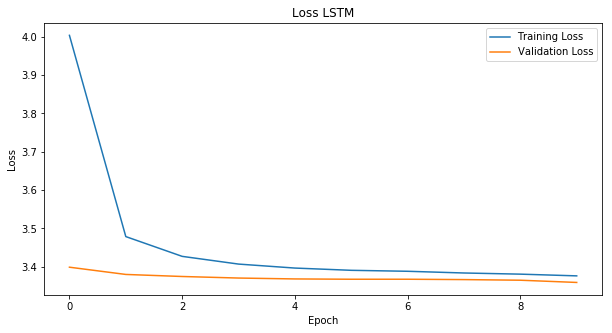

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

chars = tuple(set(text))
n_layers = 3
n_hidden = 512
dropout = 0.7
lr = 0.001

model = CharRNN(chars,
                n_hidden=n_hidden, 
                n_layers=n_layers, 
                dropout=dropout,
                mode='LSTM').to(device)

printParams(model)

train_loss, valid_loss = train(model, text, epochs=10, seq_length=300, 
                               batch_size=512, save_rate=None)

plot_loss(train_loss, valid_loss, 10, 'LSTM')

Name:    rnn.weight_ih_l0, shape:   torch.Size([1536, 112]), total params:     172032, grad params:     172032
Name:    rnn.weight_hh_l0, shape:   torch.Size([1536, 512]), total params:     786432, grad params:     786432
Name:      rnn.bias_ih_l0, shape:        torch.Size([1536]), total params:       1536, grad params:       1536
Name:      rnn.bias_hh_l0, shape:        torch.Size([1536]), total params:       1536, grad params:       1536
Name:    rnn.weight_ih_l1, shape:   torch.Size([1536, 512]), total params:     786432, grad params:     786432
Name:    rnn.weight_hh_l1, shape:   torch.Size([1536, 512]), total params:     786432, grad params:     786432
Name:      rnn.bias_ih_l1, shape:        torch.Size([1536]), total params:       1536, grad params:       1536
Name:      rnn.bias_hh_l1, shape:        torch.Size([1536]), total params:       1536, grad params:       1536
Name:    rnn.weight_ih_l2, shape:   torch.Size([1536, 512]), total params:     786432, grad params:     786432
N

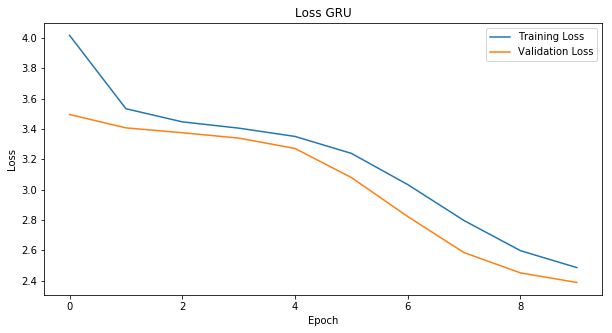

In [31]:
n_layers = 3
n_hidden = 512
dropout = 0.7
lr = 0.001

model = CharRNN(chars,
                n_hidden=n_hidden, 
                n_layers=n_layers, 
                dropout=dropout,
                mode='GRU').to(device)

printParams(model)

train_loss, valid_loss = train(model, text, epochs=10, seq_length=300, 
                               batch_size=512, save_rate=None)

plot_loss(train_loss, valid_loss, 10, 'GRU')

Name:    rnn.weight_ih_l0, shape:    torch.Size([512, 112]), total params:      57344, grad params:      57344
Name:    rnn.weight_hh_l0, shape:    torch.Size([512, 512]), total params:     262144, grad params:     262144
Name:      rnn.bias_ih_l0, shape:         torch.Size([512]), total params:        512, grad params:        512
Name:      rnn.bias_hh_l0, shape:         torch.Size([512]), total params:        512, grad params:        512
Name:    rnn.weight_ih_l1, shape:    torch.Size([512, 512]), total params:     262144, grad params:     262144
Name:    rnn.weight_hh_l1, shape:    torch.Size([512, 512]), total params:     262144, grad params:     262144
Name:      rnn.bias_ih_l1, shape:         torch.Size([512]), total params:        512, grad params:        512
Name:      rnn.bias_hh_l1, shape:         torch.Size([512]), total params:        512, grad params:        512
Name:    rnn.weight_ih_l2, shape:    torch.Size([512, 512]), total params:     262144, grad params:     262144
N

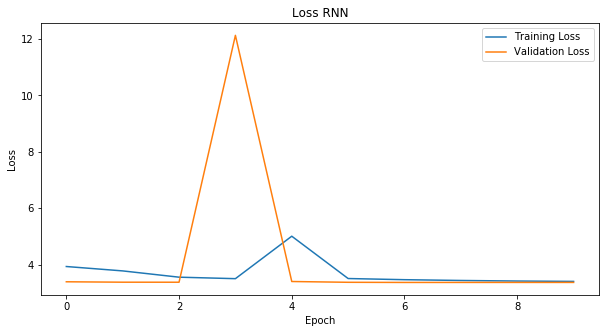

In [32]:
n_layers = 3
n_hidden = 512
dropout = 0.7
lr = 0.001

model = CharRNN(chars,
                n_hidden=n_hidden, 
                n_layers=n_layers, 
                dropout=dropout,
                mode='RNN').to(device)

printParams(model)

train_loss, valid_loss = train(model, text, epochs=10, seq_length=300, 
                               batch_size=512, save_rate=None)

plot_loss(train_loss, valid_loss, 10, 'RNN')

___
## Pretrained models
I actually trained these models for 200 epochs and saved them (but, their class definitions were different). So, I am going to load in these models, and get their outputs.


### LSTM model 200 epochs

In [51]:
class CharLSTM(nn.Module):
  
  def __init__(self, tokens, n_hidden=256, n_layers = 2, 
               dropout = 0.5, lr=0.001):
    
    super().__init__()
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.drop_val = dropout
    self.lr = lr
    
    self.chars = tokens
    self.char2int = {cc: ii for ii, cc in enumerate(tokens)}
    self.int2char = {ii: cc for cc, ii in self.char2int.items()}
    
    self.lstm = nn.LSTM(len(tokens), n_hidden, n_layers, 
                        batch_first = True, dropout = dropout)
    
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(n_hidden, len(tokens))
    
  def forward(self, b_x, h=None):
    
    b_x, h = self.lstm(b_x, h)
    b_x = self.dropout(b_x)
    b_x = b_x.contiguous().view(-1, self.n_hidden)
    b_x = self.fc(b_x)
    
    return b_x, h
  
model = load_model('modelEpoch_200_lstm', CharLSTM).to(device)

print(sample(model, 5, 2000))

Абай қарық жақсы елдің
тесебіне болды да қалып, жаңа боп алды. Бес сөзді астаған жерінің күңгісі келді. Барлық қоса жастықтар жағындағы киімдері бірі түріне біреу
көрінсін ғана тілегін қарап кетті.

Бардың қайсары жайын, жаны да жірек
ала құндай. Қазыр біті болған күліп жарап жүріп қапты. Бірақ
алғашқы жоғынды жайлай, болмайды. Абай басқа кезге келді. Бозымақтан, жүрегі күйде бұрын жатып қалды.

– Жаңағы қайраны жоқ. Бірақ қолан жайлап, жалаңақ, айдасыз қалам. Құл аттың ауырып келетін ел көңілімен
жарайтқан ауылдардың айтқанына жақан қолына берген жұртты алыстан, жылаған бірдей қалың жалған жүзі де боран жете жатты.

Абай сыртқа байқады.

Құнанбай болды да:

– Жор сонау бермейміз, таңырып, аламыздығы мастаным етті дейді. Сен жар айтып тастамаймын! - деп айтты.

– Ене барады» десе, жайлау қылды.

– Абай, айтыңыз білмейді?.. - деп, жалғыз жеткізбей, бұрын қарады. Барлық құра боп
қалған жақын қалған. Арада кірісті. Ол сөздің
ар болмаса,
тоқтап қалды.

Бірақ айтқаным да жанған жеңдей қара 

---
### GRU model 200 epochs

In [50]:
class CharGRU(nn.Module):
  
  def __init__(self, tokens, n_hidden=256, n_layers = 2, 
               dropout = 0.5, lr=0.001):
    
    super().__init__()
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.drop_val = dropout
    self.lr = lr
    
    self.chars = tokens
    self.char2int = {cc: ii for ii, cc in enumerate(tokens)}
    self.int2char = {ii: cc for cc, ii in self.char2int.items()}
    
    self.gru = nn.GRU(len(tokens), n_hidden, n_layers, 
                      batch_first = True, dropout = dropout)
    
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(n_hidden, len(tokens))
    
  def forward(self, b_x, h=None):
    
    b_x, h = self.gru(b_x, h)
    b_x = self.dropout(b_x)
    b_x = b_x.contiguous().view(-1, self.n_hidden)
    b_x = self.fc(b_x)
    
    return b_x, h

model = load_model('modelEpoch_200_gru', CharGRU).to(device)

print(sample(model, 5, 2000))

Абайды. Біреу болған бала соны білгірген
екен. Сөзіне сайлауы жас айдап, жолға көп сүйді. Құнанбай мен Жабайды
астан түре алып келген еді. Қарсы, бір-ақ келін беретін. Ол бұл екен
деген бойы жас көрінеді. Бірақ олардың көзі жатыр, сенім де, осы
ауған күндің ауылдың қалың сүйініп құшақтап, тұрып айтқан.

Бірақ қандап осы ауылдар бар ат білмейтін.

Сынымен бір сәтте Құнанбай жол бойында топырып тастап, түгел қарап,
тағы қола болып еді. Барлы сол Абайды көріп, сыр бар еткен соң,
Абай арқаға кезектеп жатпай, сала тастады. Байтас батыр жасырын
қарсы алғандай. Сонысы екен. Жұмағұл бұл кезде айтпақан арасында бар еді.
Қыстақ берген қырылын тезінен бірі күндік, салалан сала білдірген жаңа
қосыла сол күрік бай қатты арттарынан қарайға қайтады. Сөзді айтқандай
болатын. Абайды құлай бүріп, алысқан бар дән бір сауат бұрып қалған
кім ағып, қып тұр.

– Барым қара қыстарды алдың де керетті!

– Сол жалған жатқан қанымыздан айналысқа басып:

– Қоныс көп ағайылындарың, аран! Бірең сөрсі де артырасың! - 

---
### RNN model 200 epochs

In [53]:
class CharRNN(nn.Module):
  
  def __init__(self, tokens, n_hidden=256, n_layers = 2, 
               dropout = 0.5, lr=0.001):
    
    super().__init__()
    self.n_hidden = n_hidden
    self.n_layers = n_layers
    self.drop_val = dropout
    self.lr = lr
    
    self.chars = tokens
    self.char2int = {cc: ii for ii, cc in enumerate(tokens)}
    self.int2char = {ii: cc for cc, ii in self.char2int.items()}
    
    self.rnn = nn.RNN(len(tokens), n_hidden, n_layers, 
                      batch_first = True, dropout = dropout)
    
    self.dropout = nn.Dropout(dropout)
    self.fc = nn.Linear(n_hidden, len(tokens))
    
  def forward(self, b_x, h=None):
    
    b_x, h = self.rnn(b_x, h)
    b_x = self.dropout(b_x)
    b_x = b_x.contiguous().view(-1, self.n_hidden)
    b_x = self.fc(b_x)
    
    return b_x, h

model = load_model('modelEpoch_200_rnn', CharRNN).to(device)

print(sample(model, 5, 2000))

Абайың,
көріміс босында қайса, тартып ап, артың жалғыз жүргеніндi берiп отырғың, қалай
бұлалған жалайды.

Бірақ жақын жүрген сыңынан бiрдіңдiң
бiстер бай боп қалғын жоқ, түн бетін тарып, қайдан болса ды. Осы көшi екен. Боқарым жеке сеттi.

Ой жоқ тағаны ескі жаққа каткен жақын таңғанған болған, бiр қылға кісiнi кiргені алған, сағы баласы, жал қатқар болат атты да алап қалды. Барсын айлыптың бал салдар күрiсiн еретіп жатқанды, арындар болатын. Сон сойтын қолға
жыбарын бұл екi жоқ.

Боларары
қарында бар болатын!
 Абай бар жоқ бейге толағы көзге қарай күлгесің, келіп, жүргіз жақаны болырта жарағып, жарандың аса бұрын дәрсіз дылдарына қарсы жатарын тысын болмасан сенiң ма?

Құлақ балып кіпінен жатып, жайылап берiп, қыйлайдан қалаң топ күн бiр атын жердiң, жүні айтатын
болып келді.
 Балағызы, болары тасырап қайда қарылды. Ой ештер бағыны жоқ. Сүнді бетендерін, саған араз салған жоқ. Бірақ сала мен
келді. Осы күзі байырып, жарастырды. Осы баламыл бір қыста жақыр бойын айтырған жылы атаулыра,